In [0]:
%python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
%python
options = {
    "header": True,          # First row is header
    "sep": "\t",             # Tab-separated
    "inferSchema": True      # Infer schema
}

file_path_employee      = "dbfs:/FileStore/tables/BootCamp_Final_Project_Task1_Files/employee.txt"
file_path_employee_sale = "dbfs:/FileStore/tables/BootCamp_Final_Project_Task1_Files/employee_sale.txt"
file_path_customers     = "dbfs:/FileStore/tables/BootCamp_Final_Project_Task1_Files/customers.txt"
file_path_products      = "dbfs:/FileStore/tables/BootCamp_Final_Project_Task1_Files/products.txt"
file_path_sales         = "dbfs:/FileStore/tables/BootCamp_Final_Project_Task1_Files/sales.txt"

# Read the CSV file into a DataFrame and create a delta table from it
employee      = spark.read.csv(file_path_employee, **options)
employee_sale = spark.read.csv(file_path_employee_sale, **options)
customers     = spark.read.csv(file_path_customers, **options)
products      = spark.read.csv(file_path_products, **options)


sales         = spark.read.csv(file_path_sales, **options)


In [0]:
employee.display()

employee_id,employee_name,role,department
1,Employee 1,Role 2,Department 3
2,Employee 2,Role 2,Department 1
3,Employee 3,Role 1,Department 2
4,Employee 4,Role 1,Department 2
5,Employee 5,Role 1,Department 3
6,Employee 6,Role 3,Department 1
7,Employee 7,Role 3,Department 1
8,Employee 8,Role 3,Department 2
9,Employee 9,Role 2,Department 2
10,Employee 10,Role 3,Department 2


#1)Product Category vs Sales %



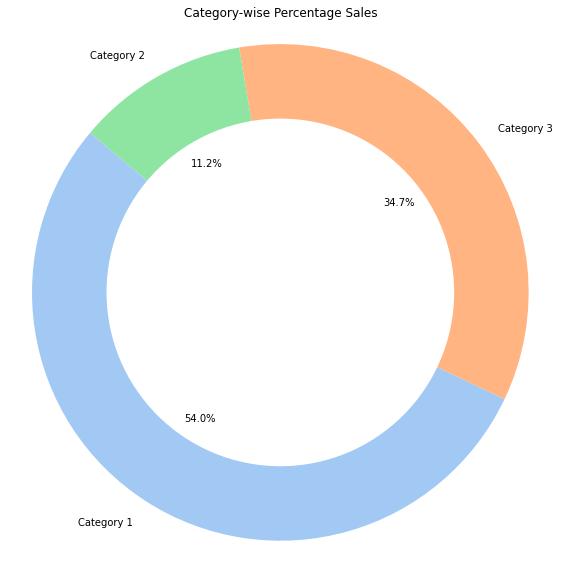

In [0]:
 



# Join products and sales DataFrames on product_id
joined_df = products.join(sales, products.product_id == sales.product_id, 'inner')

# Group by category and calculate total sales amount
category_sales = joined_df.groupby('category').agg({'amount_paid': 'sum'})

# Convert PySpark DataFrame to Pandas DataFrame
category_sales_pd = category_sales.toPandas()

# Calculate total sales amount
total_sales = category_sales_pd['sum(amount_paid)'].sum()

# Calculate percentage sales for each category
category_sales_pd['percentage_sales'] = (category_sales_pd['sum(amount_paid)'] / total_sales) * 100

# Create a pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')  # Choose a color palette
plt.pie(category_sales_pd['percentage_sales'], labels=category_sales_pd['category'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Category-wise Percentage Sales')

# Draw a circle at the center to create a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()




#### Purpose : To get insight into category wise sales of the data

 Insights :
   1) Product Category 1 has maximum sales with almost 54% 
   2) Product Category 2 has minimum sales with almost 11%

#2)product x sales qty

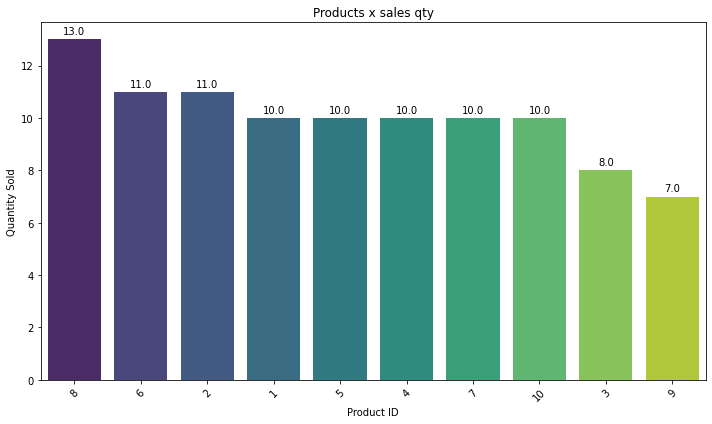

In [0]:


# Group by product_id and count the number of rows for each product (equivalent to counting the quantity sold)
product_sales = sales.groupBy('product_id').count().withColumnRenamed('count', 'quantity_sold')

# Convert the PySpark DataFrame to Pandas DataFrame for easier manipulation and plotting
product_sales_pd = product_sales.toPandas()

# Sort the DataFrame by the quantity_sold column in descending order
product_sales_pd = product_sales_pd.sort_values(by='quantity_sold', ascending=False)

# Create a bar graph using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=product_sales_pd, x='product_id', y='quantity_sold', order=product_sales_pd.sort_values('quantity_sold', ascending=False).product_id, palette='viridis')
plt.title('Products x sales qty')
plt.xlabel('Product ID')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)

# Annotate bars with quantity sold values
for bar in ax.patches:
    height = bar.get_height()
    plt.annotate(f"{height}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


Purpose : To get insight into product wise sales report
Insights :

Product 8 has maximum sales with almost 13 qty sold
followed by Product 6 which has second sales with almost 11 qty sold

Product 3 and product 9 has the least quantities sold and need special attention

### 3) Most Valuable Customers :-  Horizontal Bar Chart

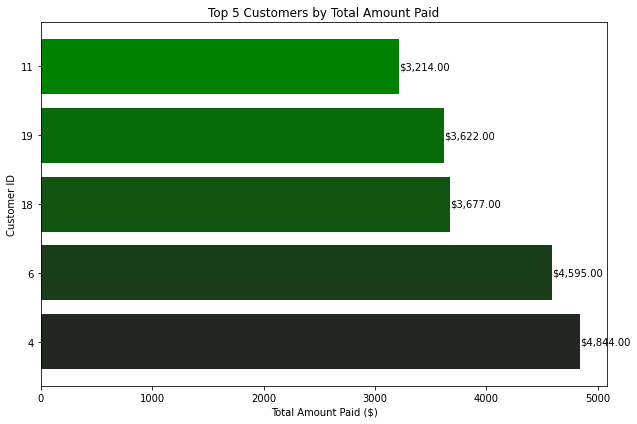

In [0]:


# Group by customer_id and calculate total amount paid
customer_totals = sales.groupBy('customer_id').sum('amount_paid').withColumnRenamed('sum(amount_paid)', 'total_amount_paid')

# Order by total_amount_paid in descending order
customer_totals = customer_totals.orderBy('total_amount_paid', ascending=False)

# Select the top 5 customers and convert to Pandas DataFrame
top_5_customers = customer_totals.limit(5).toPandas()

# Set the color palette
palette = sns.dark_palette("green", n_colors=5)

# Create the horizontal bar plot with wider bars
plt.figure(figsize=(9, 6))
bars = plt.barh(range(len(top_5_customers)), top_5_customers['total_amount_paid'], color=palette, height=0.8)  # Adjusted height

# Add annotations for each bar
for bar, value in zip(bars, top_5_customers['total_amount_paid']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"${value:,.2f}", va='center', ha='left', color='black')

# Set y-ticks and labels
plt.yticks(range(len(top_5_customers)), top_5_customers['customer_id'])

# Set labels and title
plt.xlabel('Total Amount Paid ($)')
plt.ylabel('Customer ID')
plt.title('Top 5 Customers by Total Amount Paid')

# Show plot
plt.tight_layout()
plt.show()


#### Most valueable customers
customer 4 is our top priority customer as he is responsibe for generating the highest revenue ($4844)
followed by customer 6 and so on. These 5 are our top customers and high priority assets and should be given special value for their retention

#4) Top Performing Employees    and  Poor Performing Employees

<command-996947504017901>:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


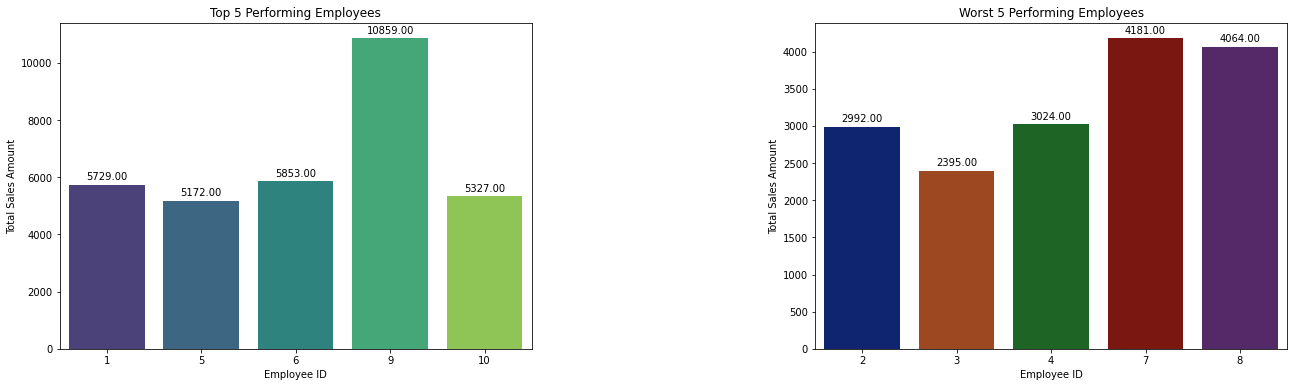

In [0]:

# Create subplots with a little gap between them
fig, axs = plt.subplots(1, 2, figsize=(22, 6), gridspec_kw={'wspace': 0.6})

# Plot for top 5 performing employees
sns.barplot(data=top_5_pd, x='employee_id', y='total_amount', ax=axs[0], palette='viridis')
axs[0].set_title('Top 5 Performing Employees')
axs[0].set_xlabel('Employee ID')
axs[0].set_ylabel('Total Sales Amount')

# Add annotations to the top of each bar
for bar in axs[0].patches:
    height = bar.get_height()
    axs[0].annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot for worst 5 performing employees
sns.barplot(data=worst_5_pd, x='employee_id', y='total_amount', ax=axs[1], palette='dark')
axs[1].set_title('Worst 5 Performing Employees')
axs[1].set_xlabel('Employee ID')
axs[1].set_ylabel('Total Sales Amount')

# Add annotations to the top of each bar
for bar in axs[1].patches:
    height = bar.get_height()
    axs[1].annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()

plt.show()



%md
#### Top Performing Employees
Employee 9 is our best performing employee and has generarated sales > 10000 alone which is almost double the 2nd best performing employee.                                         
Other than Employee 9, Emp 1,Emp 5, Emp 6, Emp 10 are our top performers and need to be appreciated 

#### Poor Performing Employees
Emp 2, Emp 3, Emp 4, Emp 7, Emp 8 are not performing upto the mark and need to improve their performance.                                                                           The management needs to pay special attention to these employees and help them improve their performance


# Monthly Sales Trend Line

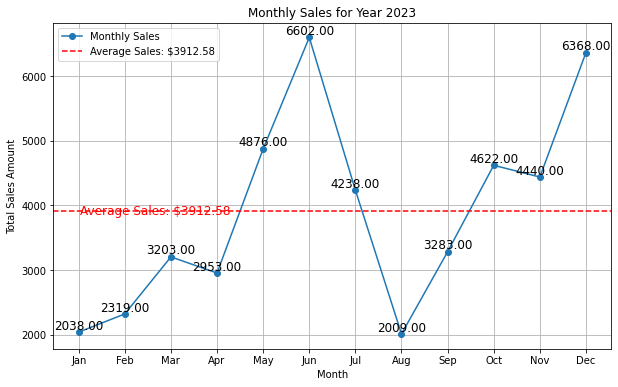

In [0]:

# Convert Spark DataFrame to Pandas DataFrame
sales_pd = sales.toPandas()

# Convert 'transaction_date' column to datetime
sales_pd['transaction_date'] = pd.to_datetime(sales_pd['transaction_date'])

# Extract year and month from 'transaction_date' column
sales_pd['year'] = sales_pd['transaction_date'].dt.year
sales_pd['month'] = sales_pd['transaction_date'].dt.month

# Group by year and month, calculate total sales amount
monthly_sales = sales_pd.groupby(['year', 'month']).agg({'amount_paid': 'sum'}).reset_index()

# Define custom month labels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Generate monthly sales visualizations for each year
for year in monthly_sales['year'].unique():
    sales_year = monthly_sales[monthly_sales['year'] == year]
    plt.figure(figsize=(10, 6))
    plt.plot(sales_year['month'], sales_year['amount_paid'], marker='o', label='Monthly Sales')
    plt.title(f'Monthly Sales for Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales Amount')
    plt.xticks(range(1, 13), months)  # Set custom month labels
    plt.grid(True)
    
    # Calculate average sales for the year
    average_sales = sales_year['amount_paid'].mean()
    
    # Plot a horizontal line for the average sales
    plt.axhline(y=average_sales, color='r', linestyle='--', label=f'Average Sales: ${average_sales:.2f}')
    
    # Add data labels to the line plot
    for i, (month, amount) in enumerate(zip(sales_year['month'], sales_year['amount_paid'])):
        plt.text(month, amount, f'{amount:.2f}', ha='center', va='bottom', fontsize=12)

    plt.legend()
    
    # Annotate the average sales amount
    plt.text(1.02, average_sales, f'Average Sales: ${average_sales:.2f}', ha='left', va='center', color='r', fontsize=12)
    
    plt.show()


The sales trend line shows that the sales are increasing from Jan to June and again decrease to the least value.                                                                    
It again takes the leap and reaches the peak till December.                                                                                                                         
We need to analyze as to what are the reasons for sudden drop of sales in the month of August and inturn try to take measures which could possibly keep the sales to the top

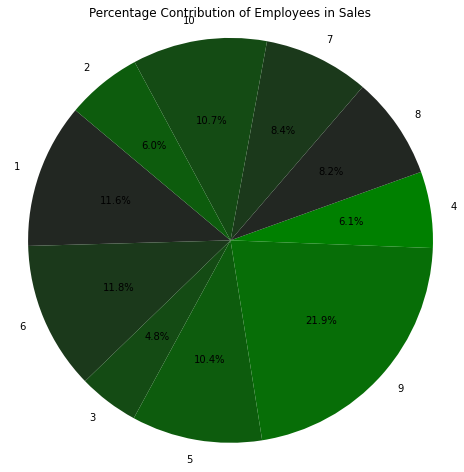

In [0]:


# Group by employee_id and calculate total sales amount
employee_sales = employee_sale.groupBy('employee_id').sum('amount').withColumnRenamed('sum(amount)', 'total_sales')

# Convert PySpark DataFrame to Pandas DataFrame for easier manipulation
employee_sales_pd = employee_sales.toPandas()

# Calculate total sales amount across all employees
total_sales = employee_sales_pd['total_sales'].sum()

# Calculate percentage contribution of each employee
employee_sales_pd['percentage_contribution'] = (employee_sales_pd['total_sales'] / total_sales) * 100

# Create a muted color palette
palette = sns.color_palette('muted')

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(employee_sales_pd['percentage_contribution'], labels=employee_sales_pd['employee_id'], autopct='%1.1f%%', startangle=140, colors=sns.dark_palette("green"))
plt.title('Percentage Contribution of Employees in Sales')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Combined Report

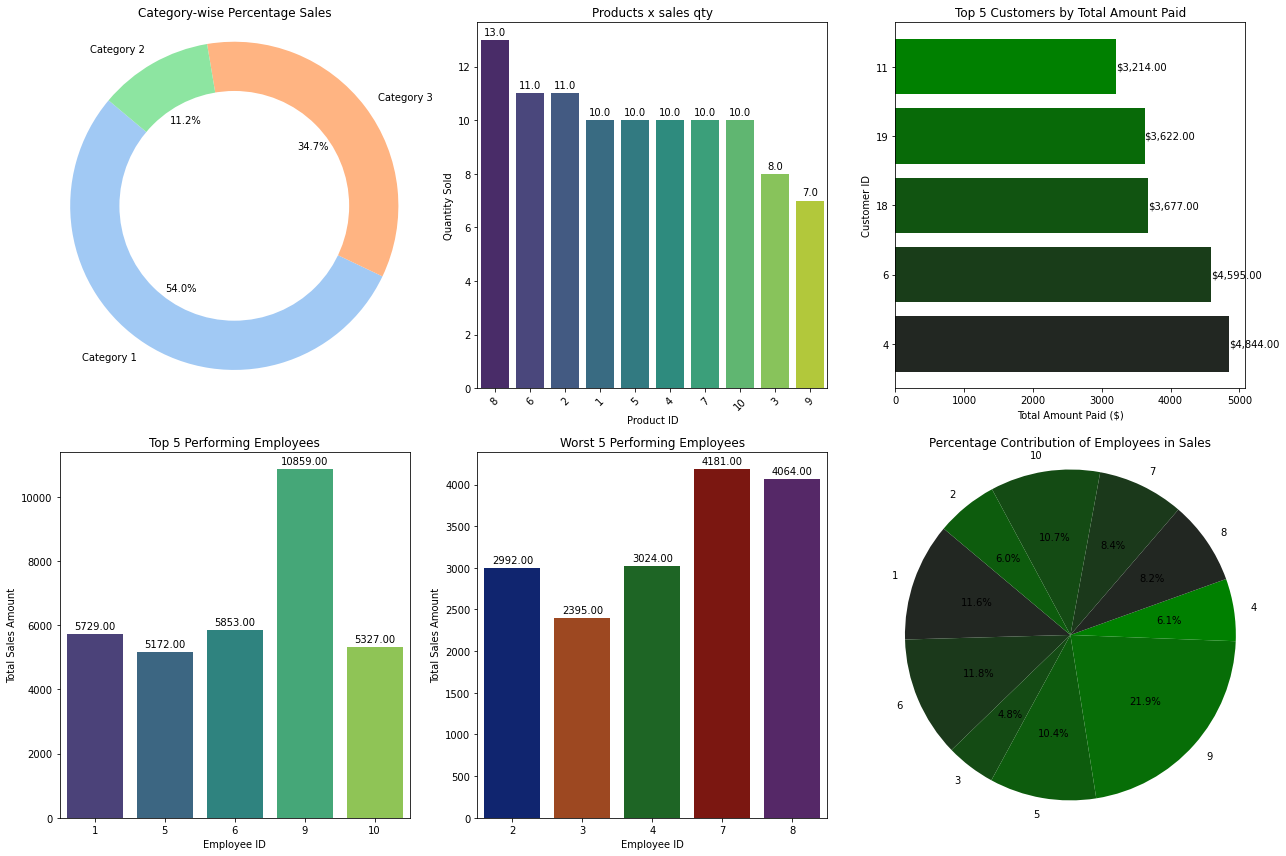

In [0]:

# Create a figure and axes for subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Plot the first graph (donut chart)
# Join products and sales DataFrames on product_id
joined_df = products.join(sales, products.product_id == sales.product_id, 'inner')

# Group by category and calculate total sales amount
category_sales = joined_df.groupby('category').agg({'amount_paid': 'sum'})

# Convert PySpark DataFrame to Pandas DataFrame
category_sales_pd = category_sales.toPandas()

# Calculate total sales amount
total_sales = category_sales_pd['sum(amount_paid)'].sum()

# Calculate percentage sales for each category
category_sales_pd['percentage_sales'] = (category_sales_pd['sum(amount_paid)'] / total_sales) * 100

# Choose a color palette
colors = sns.color_palette('pastel')

# Create a pie chart
axs[0, 0].pie(category_sales_pd['percentage_sales'], labels=category_sales_pd['category'], autopct='%1.1f%%', startangle=140, colors=colors)
axs[0, 0].set_title('Category-wise Percentage Sales')

# Draw a circle at the center to create a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
axs[0, 0].add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
axs[0, 0].axis('equal')

# Plot the second graph (bar plot)
# Group by product_id and count the number of rows for each product (equivalent to counting the quantity sold)
product_sales = sales.groupBy('product_id').count().withColumnRenamed('count', 'quantity_sold')

# Convert the PySpark DataFrame to Pandas DataFrame for easier manipulation and plotting
product_sales_pd = product_sales.toPandas()

# Sort the DataFrame by the quantity_sold column in descending order
product_sales_pd = product_sales_pd.sort_values(by='quantity_sold', ascending=False)

# Create a bar graph using Seaborn
ax = sns.barplot(data=product_sales_pd, x='product_id', y='quantity_sold', order=product_sales_pd.sort_values('quantity_sold', ascending=False).product_id, palette='viridis', ax=axs[0, 1])
ax.set_title('Products x sales qty')
ax.set_xlabel('Product ID')
ax.set_ylabel('Quantity Sold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Annotate bars with quantity sold values
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f"{height}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Plot the third graph (horizontal bar plot for top 5 customers)
# Group by customer_id and calculate total amount paid
customer_totals = sales.groupBy('customer_id').sum('amount_paid').withColumnRenamed('sum(amount_paid)', 'total_amount_paid')

# Order by total_amount_paid in descending order
customer_totals = customer_totals.orderBy('total_amount_paid', ascending=False)

# Select the top 5 customers and convert to Pandas DataFrame
top_5_customers = customer_totals.limit(5).toPandas()

# Set the color palette
palette = sns.dark_palette("green", n_colors=5)

# Create the horizontal bar plot with wider bars
bars = axs[0, 2].barh(range(len(top_5_customers)), top_5_customers['total_amount_paid'], color=palette, height=0.8)  # Adjusted height

# Add annotations for each bar
for bar, value in zip(bars, top_5_customers['total_amount_paid']):
    axs[0, 2].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"${value:,.2f}", va='center', ha='left', color='black')

# Set y-ticks and labels
axs[0, 2].set_yticks(range(len(top_5_customers)))
axs[0, 2].set_yticklabels(top_5_customers['customer_id'])

# Set labels and title
axs[0, 2].set_xlabel('Total Amount Paid ($)')
axs[0, 2].set_ylabel('Customer ID')
axs[0, 2].set_title('Top 5 Customers by Total Amount Paid')

employee_sales_total = employee_sale.groupBy('employee_id').sum('amount').withColumnRenamed('sum(amount)', 'total_amount')

# Sort employees by total sales amount
top_5_employees = employee_sales_total.orderBy('total_amount', ascending=False).limit(5)
worst_5_employees = employee_sales_total.orderBy('total_amount', ascending=True).limit(5)

# Convert PySpark DataFrame to Pandas DataFrame for plotting
top_5_pd = top_5_employees.toPandas()
worst_5_pd = worst_5_employees.toPandas()

# Create subplots with a little gap between them
sns.barplot(data=top_5_pd, x='employee_id', y='total_amount', ax=axs[1, 0], palette='viridis')
axs[1, 0].set_title('Top 5 Performing Employees')
axs[1, 0].set_xlabel('Employee ID')
axs[1, 0].set_ylabel('Total Sales Amount')

sns.barplot(data=worst_5_pd, x='employee_id', y='total_amount', ax=axs[1, 1], palette='dark')
axs[1, 1].set_title('Worst 5 Performing Employees')
axs[1, 1].set_xlabel('Employee ID')
axs[1, 1].set_ylabel('Total Sales Amount')

# Annotate top 5 performing employees' bars
for bar in axs[1, 0].patches:
    height = bar.get_height()
    axs[1, 0].annotate(f'{height:.2f}', 
                       xy=(bar.get_x() + bar.get_width() / 2, height), 
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')

# Annotate worst 5 performing employees' bars
for bar in axs[1, 1].patches:
    height = bar.get_height()
    axs[1, 1].annotate(f'{height:.2f}', 
                       xy=(bar.get_x() + bar.get_width() / 2, height), 
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')


# Calculate total sales amount across all employees
total_sales = employee_sales_pd['total_sales'].sum()

# Calculate percentage contribution of each employee
employee_sales_pd['percentage_contribution'] = (employee_sales_pd['total_sales'] / total_sales) * 100

# Create a muted color palette
palette = sns.color_palette('muted')

# Create a pie chart
ax = axs[1, 2]  # Select the sixth subplot for the pie chart
ax.pie(employee_sales_pd['percentage_contribution'], labels=employee_sales_pd['employee_id'], autopct='%1.1f%%', startangle=140, colors=sns.dark_palette("green"))
ax.set_title('Percentage Contribution of Employees in Sales')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show plot
plt.tight_layout()
plt.show()


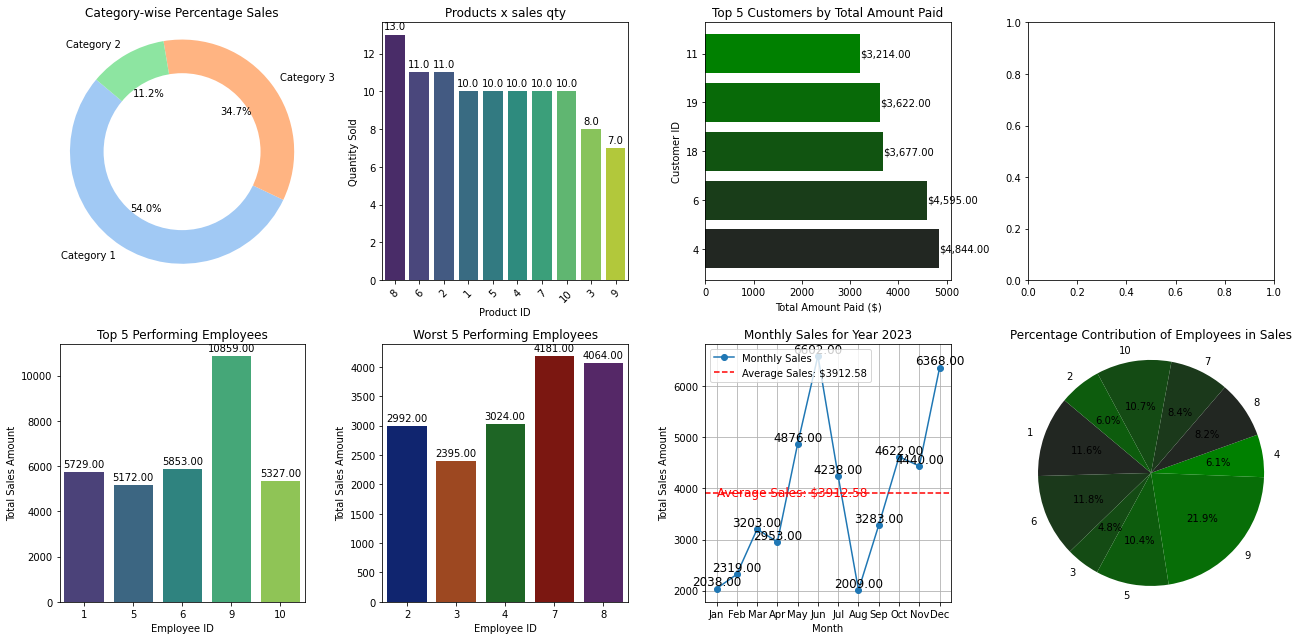

In [0]:


# Create a figure and axes for subplots
fig, axs = plt.subplots(2, 4, figsize=(18, 9))

# Plot the first graph (donut chart)
# Join products and sales DataFrames on product_id
joined_df = products.join(sales, products.product_id == sales.product_id, 'inner')

# Group by category and calculate total sales amount
category_sales = joined_df.groupby('category').agg({'amount_paid': 'sum'})

# Convert PySpark DataFrame to Pandas DataFrame
category_sales_pd = category_sales.toPandas()

# Calculate total sales amount
total_sales = category_sales_pd['sum(amount_paid)'].sum()

# Calculate percentage sales for each category
category_sales_pd['percentage_sales'] = (category_sales_pd['sum(amount_paid)'] / total_sales) * 100

# Choose a color palette
colors = sns.color_palette('pastel')

# Create a pie chart
axs[0, 0].pie(category_sales_pd['percentage_sales'], labels=category_sales_pd['category'], autopct='%1.1f%%', startangle=140, colors=colors)
axs[0, 0].set_title('Category-wise Percentage Sales')

# Draw a circle at the center to create a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
axs[0, 0].add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
axs[0, 0].axis('equal')

# Plot the second graph (bar plot)
# Group by product_id and count the number of rows for each product (equivalent to counting the quantity sold)
product_sales = sales.groupBy('product_id').count().withColumnRenamed('count', 'quantity_sold')

# Convert the PySpark DataFrame to Pandas DataFrame for easier manipulation and plotting
product_sales_pd = product_sales.toPandas()

# Sort the DataFrame by the quantity_sold column in descending order
product_sales_pd = product_sales_pd.sort_values(by='quantity_sold', ascending=False)

# Create a bar graph using Seaborn
ax = sns.barplot(data=product_sales_pd, x='product_id', y='quantity_sold', order=product_sales_pd.sort_values('quantity_sold', ascending=False).product_id, palette='viridis', ax=axs[0, 1])
ax.set_title('Products x sales qty')
ax.set_xlabel('Product ID')
ax.set_ylabel('Quantity Sold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Annotate bars with quantity sold values
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f"{height}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Plot the third graph (horizontal bar plot for top 5 customers)
# Group by customer_id and calculate total amount paid
customer_totals = sales.groupBy('customer_id').sum('amount_paid').withColumnRenamed('sum(amount_paid)', 'total_amount_paid')

# Order by total_amount_paid in descending order
customer_totals = customer_totals.orderBy('total_amount_paid', ascending=False)

# Select the top 5 customers and convert to Pandas DataFrame
top_5_customers = customer_totals.limit(5).toPandas()

# Set the color palette
palette = sns.dark_palette("green", n_colors=5)

# Create the horizontal bar plot with wider bars
bars = axs[0, 2].barh(range(len(top_5_customers)), top_5_customers['total_amount_paid'], color=palette, height=0.8)  # Adjusted height

# Add annotations for each bar
for bar, value in zip(bars, top_5_customers['total_amount_paid']):
    axs[0, 2].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"${value:,.2f}", va='center', ha='left', color='black')

# Set y-ticks and labels
axs[0, 2].set_yticks(range(len(top_5_customers)))
axs[0, 2].set_yticklabels(top_5_customers['customer_id'])

# Set labels and title
axs[0, 2].set_xlabel('Total Amount Paid ($)')
axs[0, 2].set_ylabel('Customer ID')
axs[0, 2].set_title('Top 5 Customers by Total Amount Paid')

sns.barplot(data=top_5_pd, x='employee_id', y='total_amount', ax=axs[1, 0], palette='viridis')
axs[1, 0].set_title('Top 5 Performing Employees')
axs[1, 0].set_xlabel('Employee ID')
axs[1, 0].set_ylabel('Total Sales Amount')

sns.barplot(data=worst_5_pd, x='employee_id', y='total_amount', ax=axs[1, 1], palette='dark')
axs[1, 1].set_title('Worst 5 Performing Employees')
axs[1, 1].set_xlabel('Employee ID')
axs[1, 1].set_ylabel('Total Sales Amount')

# Annotate top 5 performing employees' bars
for bar in axs[1, 0].patches:
    height = bar.get_height()
    axs[1, 0].annotate(f'{height:.2f}', 
                       xy=(bar.get_x() + bar.get_width() / 2, height), 
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')

# Annotate worst 5 performing employees' bars
for bar in axs[1, 1].patches:
    height = bar.get_height()
    axs[1, 1].annotate(f'{height:.2f}', 
                       xy=(bar.get_x() + bar.get_width() / 2, height), 
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')


# Plot the fifth graph (line chart)
# Convert Spark DataFrame to Pandas DataFrame
sales_pd = sales.toPandas()

# Convert 'transaction_date' column to datetime
sales_pd['transaction_date'] = pd.to_datetime(sales_pd['transaction_date'])

# Extract year and month from 'transaction_date' column
sales_pd['year'] = sales_pd['transaction_date'].dt.year
sales_pd['month'] = sales_pd['transaction_date'].dt.month

# Group by year and month, calculate total sales amount
monthly_sales = sales_pd.groupby(['year', 'month']).agg({'amount_paid': 'sum'}).reset_index()

# Define custom month labels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Generate monthly sales visualizations for each year
for year in monthly_sales['year'].unique():
    sales_year = monthly_sales[monthly_sales['year'] == year]
    ax = axs[1, 2]  # Select the seventh subplot for the line chart
    ax.plot(sales_year['month'], sales_year['amount_paid'], marker='o', label='Monthly Sales')
    ax.set_title(f'Monthly Sales for Year {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Sales Amount')
    ax.set_xticks(range(1, 13))  # Set x-ticks for all months
    ax.set_xticklabels(months)   # Set custom month labels
    ax.grid(True)
    
    # Calculate average sales for the year
    average_sales = sales_year['amount_paid'].mean()
    
    # Plot a horizontal line for the average sales
    ax.axhline(y=average_sales, color='r', linestyle='--', label=f'Average Sales: ${average_sales:.2f}')
    
    # Add data labels to the line plot
    for i, (month, amount) in enumerate(zip(sales_year['month'], sales_year['amount_paid'])):
        ax.text(month, amount, f'{amount:.2f}', ha='center', va='bottom', fontsize=12)

    ax.legend()
    
    # Annotate the average sales amount
    ax.text(1.02, average_sales, f'Average Sales: ${average_sales:.2f}', ha='left', va='center', color='r', fontsize=12)

# Plot the sixth graph (pie chart)
# Group by employee_id and calculate total sales amount
employee_sales = employee_sale.groupBy('employee_id').sum('amount').withColumnRenamed('sum(amount)', 'total_sales')

# Convert PySpark DataFrame to Pandas DataFrame for easier manipulation
employee_sales_pd = employee_sales.toPandas()

# Calculate total sales amount across all employees
total_sales = employee_sales_pd['total_sales'].sum()

# Calculate percentage contribution of each employee
employee_sales_pd['percentage_contribution'] = (employee_sales_pd['total_sales'] / total_sales) * 100

# Create a muted color palette
palette = sns.color_palette('muted')

# Create a pie chart
ax = axs[1, 3]  # Select the eighth subplot for the pie chart
ax.pie(employee_sales_pd['percentage_contribution'], labels=employee_sales_pd['employee_id'], autopct='%1.1f%%', startangle=140, colors=sns.dark_palette("green"))
ax.set_title('Percentage Contribution of Employees in Sales')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show plot
plt.tight_layout()
plt.show()
